# **VAE in Chapter 17 – Autoencoders and GANs from "Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow"** 

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

A couple utility functions to plot grayscale 28x28 image:

In [2]:
def plot_image(image):
    plt.imshow(image, cmap=plt.cm.gray)
    plt.axis("off")

Data used in the book

In [3]:
# (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
# X_train_full = X_train_full.astype(np.float32) / 255
# X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]

In [4]:
# X_train_full.shape

In [5]:
# (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
# X_train_full = X_train_full.astype(np.float32) / 255
# X_test = X_test.astype(np.float32) / 255
# X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
# y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

# Variational Autoencoder

In [6]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


#maintain consistent performance
tf.random.set_seed(3)

#confirm GPU is available
print("num GPUs:", len(tf.config.list_physical_devices('GPU')))

num GPUs: 1


In [8]:
dset = pd.read_csv('CData/emnist-balanced-train.csv', header=None)
dset.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,45,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
dset.shape

(112800, 785)

In [10]:
def rotate(sample):
  sample = np.fliplr(sample)
  sample = np.rot90(sample)
  return sample

In [11]:
dset = dset.loc[:,1:]
# normalize data
dset = np.expand_dims(dset,-1).astype('float32')/255
# reshape images to 28 x 28
dset = np.reshape(dset,(-1,28,28))
# # get sample image to see what they look like
# sample = dset[102]
# plt.imshow(sample, cmap=plt.cm.gray)
# plt.show
dset = np.array([rotate(x) for x in dset])

In [12]:
dset.shape

(112800, 28, 28)

Dset is too big, VAE could not run with the whole dset (112800 images). Using only 60000 images.

In [13]:
dset = dset[:60000]

In [14]:
dset.shape

(60000, 28, 28)

In [15]:
X_train, X_valid = dset[:-5000], dset[-5000:]

In [16]:
X_train.shape

(55000, 28, 28)

In [17]:
X_valid.shape

(5000, 28, 28)

In [18]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [19]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [20]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=50, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/50
430/430 [==============================] - 6s 7ms/step - loss: 0.3095 - rounded_accuracy: 0.8696 - val_loss: 0.2669 - val_rounded_accuracy: 0.8960
Epoch 2/50
430/430 [==============================] - 3s 6ms/step - loss: 0.2618 - rounded_accuracy: 0.8990 - val_loss: 0.2522 - val_rounded_accuracy: 0.9055
Epoch 3/50
430/430 [==============================] - 3s 6ms/step - loss: 0.2489 - rounded_accuracy: 0.9074 - val_loss: 0.2435 - val_rounded_accuracy: 0.9112
Epoch 4/50
430/430 [==============================] - 2s 6ms/step - loss: 0.2411 - rounded_accuracy: 0.9124 - val_loss: 0.2381 - val_rounded_accuracy: 0.9143
Epoch 5/50
430/430 [==============================] - 3s 6ms/step - loss: 0.2364 - rounded_accuracy: 0.9154 - val_loss: 0.2352 - val_rounded_accuracy: 0.9159
Epoch 6/50
430/430 [==============================] - 3s 6ms/step - loss: 0.2333 - rounded_accuracy: 0.9174 - val_loss: 0.2312 - val_rounded_accuracy: 0.9186
Epoch 7/50
430/430 [==============================] 

In [21]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 143ms/step


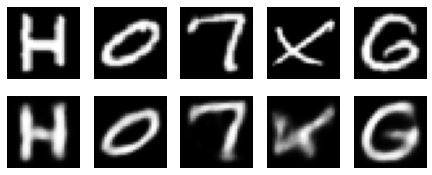

In [22]:
show_reconstructions(variational_ae)
plt.show()

In [23]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap=plt.cm.gray)
        plt.axis("off")

Saving figure vae_generated_images_plot


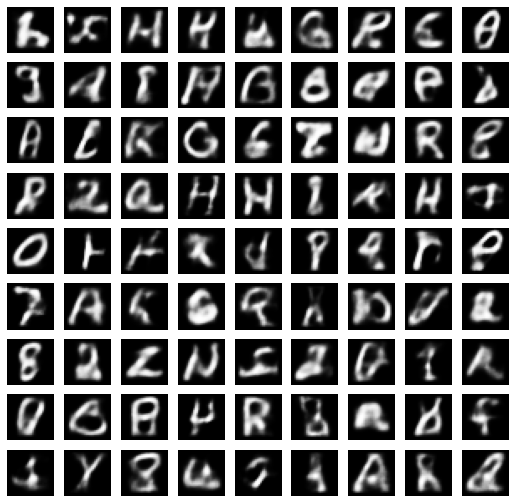

In [27]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[81, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 9)
save_fig("vae_generated_images_plot", tight_layout=False)

Results look fuzzier in comparison to the ones from the GAN. Otherwise, they are quite similar if not better.